# Подготовительный этап

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
path_csv_test = "/content/drive/MyDrive/Data/under/data/intents_test.csv"
path_csv_train = "/content/drive/MyDrive/Data/under/data/intents_train.csv"
path_csv_predict = "/content/drive/MyDrive/Data/under/data/intents_predict.csv"
path_csv_predict_m = "/content/drive/MyDrive/Data/under/data/intents_predict_m.csv"
path_model = "/content/drive/MyDrive/Data/under/data/model_bert1"
bert_vocab = "/content/drive/MyDrive/Data/under/data/vocab.txt"
bert_ckpt_file = "/content/drive/MyDrive/Data/under/data/bert_model.ckpt"
bert_config_file = "/content/drive/MyDrive/Data/under/data/bert_config.json"

In [ ]:
!pip uninstall tensorflow 
!pip install tensorflow==2.3.0

In [ ]:
!pip install bert-for-tf2

In [5]:
from bert.tokenization.bert_tokenization import FullTokenizer
import numpy as np
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert import BertModelLayer
from tensorflow.io.gfile import GFile
from sklearn.model_selection import train_test_split
import pandas as pd
import datetime

In [6]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [7]:
from tensorflow import keras
# from keras.layers.core import Dense, Dropout, Activation
# from keras.layers import Lambda, Input, Dense, Dropout, Activation
# from keras import Model

# Токенайзер для разбивки предложений

In [11]:
tokenizer = FullTokenizer(
  vocab_file=bert_vocab
)

# Класс для токенизации предоложений, и их дальнейший представление в числовом формате

In [12]:
class IntentDetectionData:
  DATA_COLUMN = "text"
  LABEL_COLUMN = "intent"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    train, test = map(lambda df: df.reindex(df[IntentDetectionData.DATA_COLUMN].str.len().sort_values().index), [train, test])
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in df.iterrows():
      text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

# Модель с использованием берт настроек

In [13]:
def create_model(max_seq_len, bert_ckpt_file):

  with GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

# Готовим данные

In [14]:
train_df = pd.read_csv(path_csv_train, sep=',')
train_df[:3]

,text,intent
0,Carbon fiber bike,Bike Types
1,budget bikes,Bike Types
2,professional bikes,Bike Types


In [15]:
X_train, X_test, y_train, y_test = train_test_split(train_df[['text']], train_df['intent'], test_size=0.20, random_state=21)

In [16]:
train = pd.concat([X_train, y_train], axis=1)

In [17]:
test = pd.concat([X_test, y_test], axis=1)

# Проверяем баланс данных

In [18]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

In [ ]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


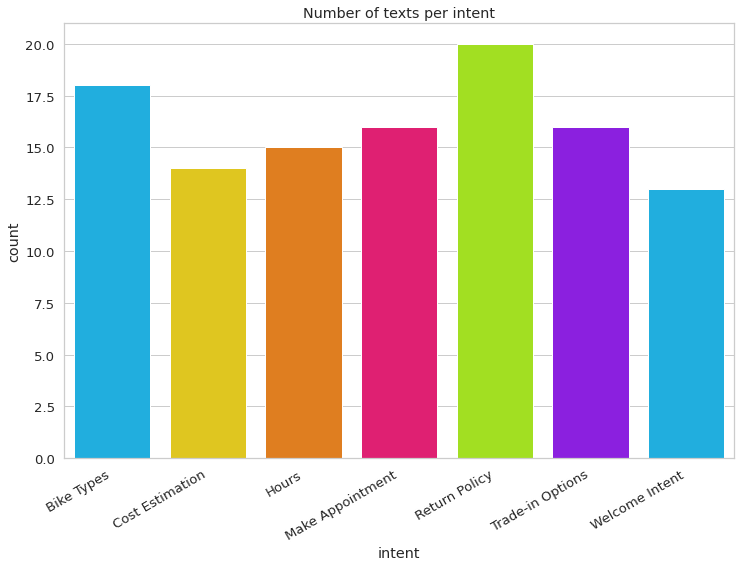

In [ ]:

chart = sns.countplot(train_df.intent, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

# Обрабатываем дата фрайм и компилим модель

In [19]:
classes = train.intent.unique().tolist()
print(classes)

data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)

['Return Policy', 'Make Appointment', 'Bike Types', 'Cost Estimation', 'Hours', 'Trade-in Options', 'Welcome Intent']
max seq_len 19


In [20]:
data.train_x

array([[  101,  8081,   102, ...,     0,     0,     0],
       [  101,  7592,   102, ...,     0,     0,     0],
       [  101, 25416,  8630, ...,     0,     0,     0],
       ...,
       [  101,  2054,  2024, ...,     0,     0,     0],
       [  101,  2129,  2146, ...,     0,     0,     0],
       [  101,  1045,  1005, ...,  2033,     0,     0]])

In [21]:
data.train_y

array([1, 6, 0, 0, 6, 4, 1, 1, 1, 6, 5, 6, 2, 4, 6, 2, 2, 5, 4, 2, 1, 4,
       4, 0, 2, 1, 4, 5, 0, 6, 4, 2, 6, 5, 2, 2, 4, 0, 0, 2, 6, 3, 4, 0,
       5, 5, 6, 2, 1, 1, 0, 3, 4, 3, 5, 5, 0, 2, 1, 5, 3, 0, 0, 1, 2, 6,
       3, 2, 3, 4, 4, 2, 5, 0, 0, 1, 3, 5, 5, 0, 1, 2, 0, 0, 6, 3, 0, 0,
       2])

In [22]:
data.max_seq_len

19

In [42]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 19, 768)
Done loading 196 BERT weights from: /content/drive/MyDrive/Data/under/data/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fed77b8aa90> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [35]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 19)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 19, 768)           108890112 
_________________________________________________________________
lambda_2 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 768)               590592    
_________________________________________________________________
dropout_5 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 7)                

In [43]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

# Тренировка

In [46]:
log_dir = "log/intent_detection2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_data = (data.test_x, data.test_y),
  batch_size=16,
  shuffle=True,
  epochs=5,
  callbacks=[tensorboard_callback]
)

Epoch 1/5
6/6 [==============================] - 15s 2s/step - loss: 1.2811 - acc: 0.9551 - val_loss: 1.4184 - val_acc: 0.8261
Epoch 2/5
6/6 [==============================] - 15s 2s/step - loss: 1.2539 - acc: 0.9551 - val_loss: 1.4043 - val_acc: 0.7826
Epoch 3/5
6/6 [==============================] - 15s 2s/step - loss: 1.2463 - acc: 0.9888 - val_loss: 1.4008 - val_acc: 0.7391
Epoch 4/5
6/6 [==============================] - 15s 2s/step - loss: 1.2381 - acc: 0.9775 - val_loss: 1.3903 - val_acc: 0.7391
Epoch 5/5
6/6 [==============================] - 16s 3s/step - loss: 1.2398 - acc: 0.9888 - val_loss: 1.3780 - val_acc: 0.8261


In [47]:
model.save(path_model)

In [48]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)
print("train acc", train_acc)
print("test acc", test_acc)

1/1 [==============================] - 0s 3ms/step - loss: 1.3780 - acc: 0.8261
train acc 1.0
test acc 0.8260869383811951


# Что получилось

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
print(classification_report(data.test_y, y_pred, target_names=classes))

                  precision    recall  f1-score   support

   Return Policy       1.00      1.00      1.00         2
Make Appointment       1.00      0.75      0.86         4
      Bike Types       0.67      1.00      0.80         2
 Cost Estimation       1.00      1.00      1.00         6
           Hours       1.00      1.00      1.00         3
Trade-in Options       0.60      0.75      0.67         4
  Welcome Intent       1.00      0.50      0.67         2

        accuracy                           0.87        23
       macro avg       0.90      0.86      0.86        23
    weighted avg       0.90      0.87      0.87        23



# Сохраняем тестовые предсказания в файл

In [50]:
df_test = pd.read_csv(path_csv_test, header=0)
df_test.head()

,text
0,Do I need to replace my helmet?
1,My bike was stolen what should I do?
2,What types or choices of bikes do I have in yo...
3,Do you rent bikes?
4,I'm a student and I'm doing a project...


In [51]:
pred_tokens = map(tokenizer.tokenize, df_test['text'])
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

h = []
for text, label in zip(df_test['text'], predictions):
  h.append({"text": text, "intent": classes[label]})
df_test = pd.DataFrame(h)
df_test.to_csv(path_csv_predict)

In [49]:
model_g = keras.models.load_model(path_model)

In [30]:
_, train_acc = model_g.evaluate(data.train_x, data.train_y)
_, test_acc = model_g.evaluate(data.test_x, data.test_y)
print("train acc", train_acc)
print("test acc", test_acc)

1/1 [==============================] - 0s 4ms/step - loss: 1.3636 - acc: 0.7826
train acc 0.9775280952453613
test acc 0.782608687877655


In [53]:
pred_tokens = map(tokenizer.tokenize, df_test['text'])
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model_g.predict(pred_token_ids).argmax(axis=-1)

h = []
for text, label in zip(df_test['text'], predictions):
  h.append({"text": text, "intent": classes[label]})
df_test = pd.DataFrame(h)
df_test.to_csv(path_csv_predict_m)